Code based on https://github.com/pytorch/examples/blob/master/mnist/main.py

In this exercise, we are going to implement a [UNet-like](https://arxiv.org/pdf/1505.04597.pdf) architecture for the semantic segmentation task.
The model is trained on the [CamVid](https://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/) dataset.

Tasks:

    1. Implement the missing pieces in the code.
    2. Check that the given implementation reaches over 70% test accuracy after 10-15 epochs.
    3. Check how segmentations produced by the model compare to ground truth segementations.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from PIL import Image
from typing import List, Tuple

In [2]:
class UNetConvolutionStack(nn.Module):
    def __init__(self, in_channel: int, out_channel: int):
        super(UNetConvolutionStack, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        x = self.conv(x)
        return x

In [3]:
class EncoderStack(nn.Module):
    def __init__(self, in_channel: int, out_channel: int, first_layer: bool = False):
        super(EncoderStack, self).__init__()
        if first_layer:
            self.down = nn.Sequential(
                UNetConvolutionStack(in_channel, out_channel),
                UNetConvolutionStack(out_channel, out_channel),
            )
        else:
            self.down = nn.Sequential(
                nn.MaxPool2d((2, 2)),
                UNetConvolutionStack(in_channel, out_channel),
                UNetConvolutionStack(out_channel, out_channel),
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.down(x)
        return x

In [21]:
class DecoderStack(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(DecoderStack, self).__init__()
        self.upsample = nn.ConvTranspose2d(
            in_channel, in_channel, 3, stride=2, padding=1
        )
        self.up = nn.Sequential(
            UNetConvolutionStack(in_channel + out_channel, out_channel),
            UNetConvolutionStack(out_channel, out_channel),
        )

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        # TODO: implement skip connections.
        # hint: x is the output of previous decoder layer,
        # y is the output of corresponding encoder layer.
        # Based on the arguments of the constructor,
        # how should x and y be combined?
        residual = x
        x = self.upsample(x, output_size=y.shape)
        return self.up(torch.concat([x, y], dim=1))


In [22]:
class UNet(nn.Module):
    def __init__(self, encoder_channels: int, decoder_channels: int, num_classes: int):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.conv = nn.Conv2d(
            decoder_channels[-1], num_classes, kernel_size=3, padding=1
        )

        encoder_sizes = zip(
            range(len(encoder_channels)), encoder_channels, encoder_channels[1:]
        )
        for idx, in_size, out_size in encoder_sizes:
            if idx > 0:
                self.encoder.append(EncoderStack(in_size, out_size))
            else:
                self.encoder.append(EncoderStack(in_size, out_size, first_layer=True))

        decoder_sizes = zip(decoder_channels, decoder_channels[1:])
        for in_size, out_size in decoder_sizes:
            self.decoder.append(DecoderStack(in_size, out_size))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement UNet's forward pass.
        # hint: Remember to store outputs of subsequent
        # encoder layers to use as input to decoder layers!
        # Do not forget about the final convolution.
        old_x = []
        for en in self.encoder:
          x = en(x)
          old_x.append(x)

        for mem, dec in zip(reversed(old_x[:-1]), self.decoder):
          x = dec(x, mem)
          # x = torch.concat([x, mem], dim=1)

        return self.conv(x)




In [23]:
def train(
    model: torch.nn.Module,
    device: torch.device,
    train_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    log_interval: int,
):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        log_probs = F.log_softmax(output, dim=1)
        loss = F.nll_loss(log_probs, target)
        pred = log_probs.argmax(
            dim=1, keepdim=True
        )  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            _, _, image_width, image_height = data.size()
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
    print(
        "Train accuracy: {}/{} ({:.0f}%)".format(
            correct,
            (len(train_loader.dataset) * image_width * image_height),
            100.0 * correct / (len(train_loader.dataset) * image_width * image_height),
        )
    )


def test(
    model: torch.nn.Module,
    device: torch.device,
    test_loader: torch.utils.data.DataLoader,
):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            log_probs = F.log_softmax(output, dim=1)
            test_loss += F.nll_loss(
                log_probs,
                target,
                reduction="sum",
            ).item()  # sum up batch loss
            pred = log_probs.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    _, _, image_width, image_height = data.size()
    test_loss /= len(test_loader.dataset) * image_width * image_height

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            (len(test_loader.dataset) * image_width * image_height),
            100.0 * correct / (len(test_loader.dataset) * image_width * image_height),
        )
    )

In [7]:
batch_size = 50
test_batch_size = 1000
epochs = 15
lr = 2e-3
use_cuda = True
seed = 1
log_interval = 10
test_size = 80
data_root = "../data"

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
num_classes = 32

In [8]:
use_cuda = use_cuda and torch.cuda.is_available()

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {"batch_size": batch_size}
test_kwargs = {"batch_size": test_batch_size}
if use_cuda:
    cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

In [9]:
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        root_dir: str,
        filenames: List[str],
        transform: torch.nn.Module = None,
        target_transform: torch.nn.Module = None,
    ):
        self.root_dir = root_dir
        self.filenames = filenames
        self.transform = transform
        self.target_transform = target_transform
        self.transformed_data_dir = os.path.join(root_dir, "transformed")
        if not os.path.exists(self.transformed_data_dir):
            os.mkdir(self.transformed_data_dir)
            os.mkdir(os.path.join(self.transformed_data_dir, "images"))
            os.mkdir(os.path.join(self.transformed_data_dir, "labels"))

    def __len__(self) -> int:
        return len(self.filenames)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        filename = self.filenames[idx]

        transformed_image_path = os.path.join(
            self.transformed_data_dir, "images", filename
        )
        transformed_target_path = os.path.join(
            self.transformed_data_dir, "labels", filename
        )
        if os.path.exists(transformed_image_path) and os.path.exists(
            transformed_target_path
        ):
            img = torch.load(transformed_image_path, weights_only=False)
            target = torch.load(transformed_target_path, weights_only=False)
        else:
            image_path = os.path.join(
                self.root_dir, "701_StillsRaw_full", f"{filename}.png"
            )
            target_path = os.path.join(self.root_dir, "labels", f"{filename}_L.png")

            img = Image.open(image_path).convert("RGB")
            target = Image.open(target_path)

            if self.transform is not None:
                img = self.transform(img)
            if self.target_transform is not None:
                target = self.target_transform(target)
            # Applying transformations takes a long. So we do this only once,
            # then save transformed tensors to files and read them when they are needed again.
            # This significantly speeds up next iterations over dataset.
            torch.save(img, transformed_image_path)
            torch.save(target, transformed_target_path)

        return img, target

In [10]:
# Download dataset
!mkdir -p {data_root}
!wget -c -P {data_root} https://datasets.cms.waikato.ac.nz/ufdl/data/camvid/701_StillsRaw_full.zip
!wget -c -P {data_root} https://datasets.cms.waikato.ac.nz/ufdl/data/camvid/LabeledApproved_full.zip
!wget -c -P {data_root} https://datasets.cms.waikato.ac.nz/ufdl/data/camvid/label_colors.txt
!if [[ ! -d {data_root}/701_StillsRaw_full ]]; then unzip {data_root}/701_StillsRaw_full.zip -d {data_root}; fi
!if [[ ! -d {data_root}/labels ]]; then unzip {data_root}/LabeledApproved_full.zip -d {data_root}/labels; fi
!rm {data_root}/701_StillsRaw_full/Seq05VD_f02610.png 2>/dev/null
!rm {data_root}/labels/Seq05VD_f02610_L.png 2>/dev/null

--2024-11-27 16:26:27--  https://datasets.cms.waikato.ac.nz/ufdl/data/camvid/701_StillsRaw_full.zip
Resolving datasets.cms.waikato.ac.nz (datasets.cms.waikato.ac.nz)... 104.22.22.233, 104.22.23.233, 172.67.20.185, ...
Connecting to datasets.cms.waikato.ac.nz (datasets.cms.waikato.ac.nz)|104.22.22.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 584553911 (557M) [application/zip]
Saving to: ‘../data/701_StillsRaw_full.zip’

701_StillsRaw_full. 100%[===================>] 557.47M  7.57MB/s    in 62s     

2024-11-27 16:27:31 (8.96 MB/s) - ‘../data/701_StillsRaw_full.zip’ saved [584553911/584553911]

--2024-11-27 16:27:31--  https://datasets.cms.waikato.ac.nz/ufdl/data/camvid/LabeledApproved_full.zip
Resolving datasets.cms.waikato.ac.nz (datasets.cms.waikato.ac.nz)... 104.22.22.233, 104.22.23.233, 172.67.20.185, ...
Connecting to datasets.cms.waikato.ac.nz (datasets.cms.waikato.ac.nz)|104.22.22.233|:443... connected.
HTTP request sent, awaiting response... 200 

In [11]:
labels_colors = open(os.path.join(data_root, "label_colors.txt"), "r").readlines()
labels_colors = [
    torch.tensor(list(map(int, line.split()[:3]))) for line in labels_colors
]
filenames = [
    fname[:-4] for fname in os.listdir(os.path.join(data_root, "701_StillsRaw_full"))
]
filenames_train = filenames[:-test_size]
filenames_test = filenames[-test_size:]


def rgb_to_single_color(x: torch.Tensor) -> torch.Tensor:
    ret = torch.zeros(x.shape[1], x.shape[2], dtype=torch.long)
    for single_color, rgb_colors in enumerate(labels_colors):
        rgb_colors = rgb_colors.unsqueeze(1).unsqueeze(2)
        indices = torch.all(torch.eq(x, rgb_colors), dim=0)
        ret[indices] = single_color
    return ret


input_resize = transforms.Resize((240, 320))
input_transform = transforms.Compose(
    [
        input_resize,
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

target_resize = transforms.Resize((240, 320), interpolation=InterpolationMode.NEAREST)
target_transform = transforms.Compose(
    [
        target_resize,
        transforms.PILToTensor(),
        transforms.Lambda(rgb_to_single_color),
    ]
)

train_dataset = SegmentationDataset(
    data_root,
    filenames_train,
    transform=input_transform,
    target_transform=target_transform,
)
test_dataset = SegmentationDataset(
    data_root,
    filenames_test,
    transform=input_transform,
    target_transform=target_transform,
)

train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **train_kwargs)

In [24]:
model = UNet(
    encoder_channels=[3, 8, 16, 32],
    decoder_channels=[32, 16, 8],
    num_classes=num_classes,
).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)

Train Epoch: 1 [0/620 (0%)]	Loss: 3.540242
Train Epoch: 1 [500/620 (77%)]	Loss: 2.483255
Train accuracy: 13672459/47616000 (29%)
Test set: Average loss: 2.5869, Accuracy: 1650663/6144000 (27%)

Train Epoch: 2 [0/620 (0%)]	Loss: 2.345545
Train Epoch: 2 [500/620 (77%)]	Loss: 1.939569
Train accuracy: 23336111/47616000 (49%)
Test set: Average loss: 2.2006, Accuracy: 2579664/6144000 (42%)

Train Epoch: 3 [0/620 (0%)]	Loss: 1.819999
Train Epoch: 3 [500/620 (77%)]	Loss: 1.599872
Train accuracy: 26564104/47616000 (56%)
Test set: Average loss: 1.9362, Accuracy: 2948201/6144000 (48%)

Train Epoch: 4 [0/620 (0%)]	Loss: 1.522327
Train Epoch: 4 [500/620 (77%)]	Loss: 1.371676
Train accuracy: 29215618/47616000 (61%)
Test set: Average loss: 1.6451, Accuracy: 3338191/6144000 (54%)

Train Epoch: 5 [0/620 (0%)]	Loss: 1.379771
Train Epoch: 5 [500/620 (77%)]	Loss: 1.266894
Train accuracy: 30560897/47616000 (64%)
Test set: Average loss: 1.4314, Accuracy: 3753703/6144000 (61%)

Train Epoch: 6 [0/620 (0%)]	Lo

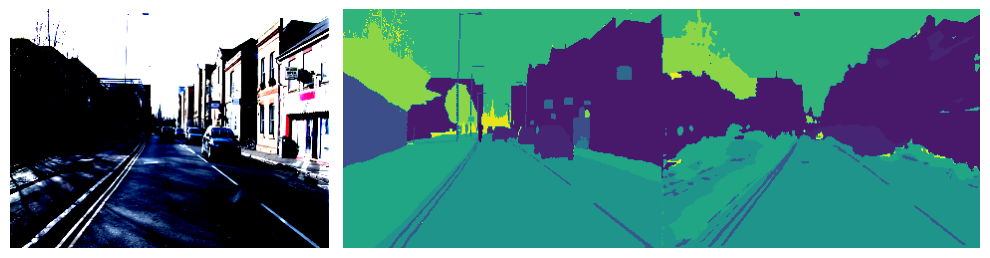

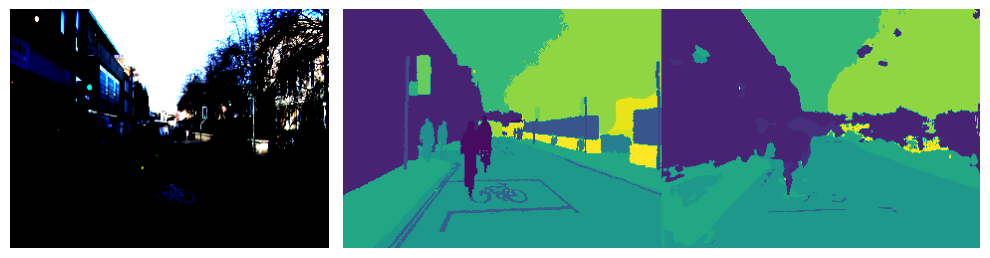

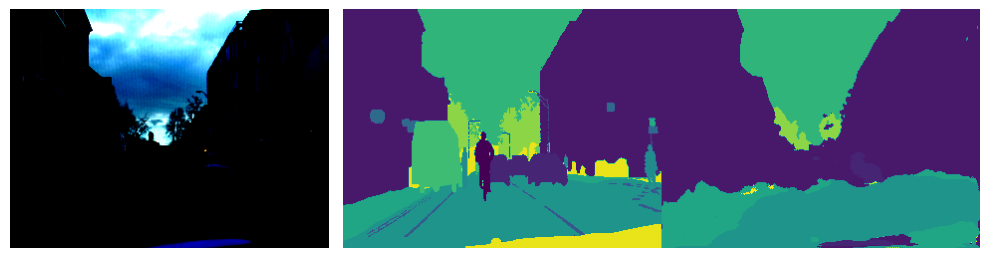

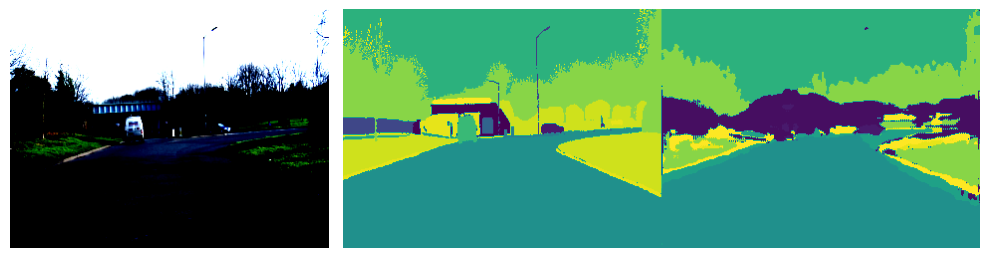

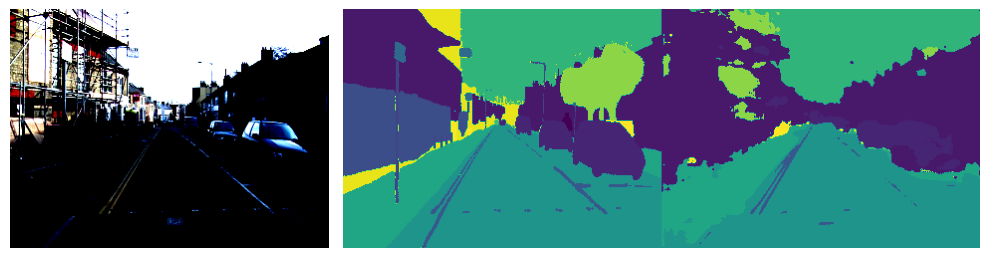

In [25]:
data, target = next(iter(test_loader))
output = model(data.to(device))
pred = output.argmax(dim=1, keepdim=True).to("cpu")

for i in range(5):
    image = data[i].permute(1, 2, 0).numpy()
    target_segmentation = target[i]
    pred_segmentation = pred[i].squeeze()

    fig, axes = plt.subplots(
        1, 2, figsize=(10, 20), gridspec_kw={"width_ratios": [1, 2]}
    )
    segmentations = torch.hstack([target_segmentation, pred_segmentation])
    segmentations = segmentations.unsqueeze(2).numpy()
    axes[0].imshow(np.clip(image, 0, 1))
    axes[0].axis("off")
    axes[1].imshow(segmentations)
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()